Methods 3 - Decision Trees
--------------------------
4.2.2020  
Mathematics and Methods in Machine Learning and Neural Networks    
Helsinki Metropolia University of Applied Sciences

In this exercise, the goal is to construct a decision tree that predicts whether a website is a phishing site or not.

The result will contain:

- an image of the decision tree
- written instructions for decision-making
- accuracy estimate

Data source: https://archive.ics.uci.edu/ml/datasets/phishing+websites

In [305]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import graphviz

__Load Data:__

In [306]:
url = r'http://users.metropolia.fi/~simomake/coursework/ml/phishing.csv'
df = pd.read_csv(url, 
                 sep = ';', 
                 index_col = None)

In [307]:
df['Result'] = df['Result'].astype(pd.api.types.CategoricalDtype(ordered=False))
df

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWindow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1,-1,1,-1,1,1,1,1,-1,-1,...,-1,-1,1,1,-1,-1,1,1,1,1
11051,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,1,1,1,1,1,1,-1,1,-1
11052,1,-1,1,1,1,-1,1,-1,-1,1,...,1,1,1,1,1,-1,1,0,1,-1
11053,-1,-1,1,1,1,-1,-1,-1,1,-1,...,-1,1,1,1,1,-1,1,1,1,-1


__All data fields are categorical. It would be interesting to try e.g. the ID3 tree algorithm on this. Unfortunately, scikit-learn's implementation if decision trees doesn't support categorical input variables.__

In [308]:
colnames = np.array(list(df))
colnames

array(['having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State',
       'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token',
       'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH',
       'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover',
       'RightClick', 'popUpWindow', 'Iframe', 'age_of_domain',
       'DNSRecord', 'web_traffic', 'Page_Rank', 'Google_Index',
       'Links_pointing_to_page', 'Statistical_report', 'Result'],
      dtype='<U27')

In [309]:
# extract input data into a data frame
X = df.loc[:, 'having_IP_Address':'Statistical_report']

# extract response variable (class variable) into a series
y = df.loc[:, 'Result']

In [310]:
# split validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [311]:
classifier = tree.DecisionTreeClassifier(max_depth=2) # additional depth offers negligible benefit
classifier.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [312]:
classifier.classes_

array([-1,  1], dtype=int64)

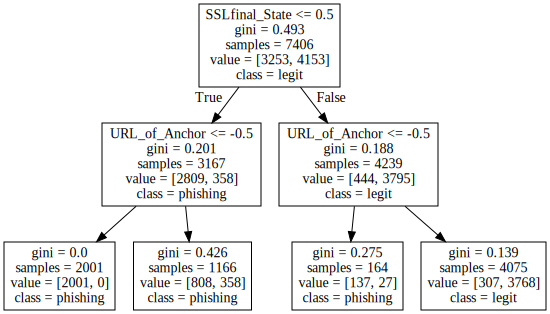

In [313]:
# visualize
dot_data = tree.export_graphviz(classifier, out_file=None, label='all', feature_names=colnames[:30], class_names=['phishing','legit'])
graph = graphviz.Source(dot_data) 
graph

Instructions for detecting a phishing site:
-------------------------------------------

The feature `SSLfinal_State` is the most important one in deciding whether or not a website is a phishing site. According to our decision tree and dataset documentation this means, that:

- If https is not in use or if https certificate issuer is not trusted (`SSLfinal_State equals -1 or 0`)
    - => PHISHING SITE
- Otherwise, if more than 67 % of the website's &lt;a&gt; tags link to another domain, or link to no web page (`URL_of_Anchor equals -1`)
    - => PHISHING SITE
- Otherwise
    - => LEGITIMATE SITE

These rules allow us to detect phishing sites at a 91 % accuracy, according to the metrics below. Adding the second layer of depth (`URL_of_Anchor` test) offered little benefit (&lt;&nbsp;2&nbsp;%) in terms of accuracy.

Metrics for training set:
-------------------------

In [314]:
# predict
y_train_pred = classifier.predict(X_train)

# output confusion matrix for training set
cm = confusion_matrix(y_train, y_train_pred)
print("Confusion matrix for training set:\n", cm)

accuracy = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
print("Accuracy calculated from the training set: %.3f" % (accuracy))
print("Classification report for training set:")
print(classification_report(y_train, y_train_pred, target_names=['phishing', 'legit']))

Confusion matrix for training set:
 [[2946  307]
 [ 385 3768]]
Accuracy calculated from the training set: 0.907
Classification report for training set:
              precision    recall  f1-score   support

    phishing       0.88      0.91      0.89      3253
       legit       0.92      0.91      0.92      4153

    accuracy                           0.91      7406
   macro avg       0.90      0.91      0.91      7406
weighted avg       0.91      0.91      0.91      7406



Metrics for testing set:
------------------------

__Actual performance evaluation using unseen data__

In [315]:
# predict
y_test_pred = classifier.predict(X_test)

# output confusion matrix for training set
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix for training set:\n", cm)

print("Accuracy calculated from the testing set: %.3f" % classifier.score(X_test, y_test))
print("Classification report for testing set:")
print(classification_report(y_test, y_test_pred, target_names=['phishing', 'legit']))

Confusion matrix for training set:
 [[1479  166]
 [ 178 1826]]
Accuracy calculated from the testing set: 0.906
Classification report for testing set:
              precision    recall  f1-score   support

    phishing       0.89      0.90      0.90      1645
       legit       0.92      0.91      0.91      2004

    accuracy                           0.91      3649
   macro avg       0.90      0.91      0.90      3649
weighted avg       0.91      0.91      0.91      3649



__There is no significant discrepancy in model performance between training and testing set. This indicates that we're good and the model should not be overfitted.__